# Mini-projet Image : Tomographie

5GMM N - Nicolas Dublé, Valentin Fouqueau, Elizabeth Fu, Simon Treillou


La Tomographie est une technique de construction d'image d'objets 3D à partir de différentes coupes de cet objet. Différentes catégories de tomographie existent, on s'intéresse à la CT (Computerized tomography).
En CT, les différentes coupes de l'objet sont acquises par la projection de rayons X sur l'objet à différents angles. D'un côté de l'objet on a la source d'émission de rayon X et de l'autre on a les capteurs. Dans notre cas on considère des rayons x parallèles (il en existe d'autres types).

L'idée globale est que l'acquisition de coupes de l'objet à différents angles permet de reconstruire le contour de l'objet. Dans le cas d'objet non-homogène (ex le corps humain en imagerie médicale), on aimerait acquérir la structure interne de l'objet.

Lorsqu'un rayon X traverse une matière, il perd une certaine quantité d'énergie, qui se traduit par une perte d'intensité mesurée par les capteurs. Il est assez logique aussi de comprendre que plus un matériau est dense, plus on perd d'intensité. Dans le cas d'un objet non-homogène, on aimerait capter les différentes pertes d'intensités au cours de la traversée du rayon X. Lorsqu'on projète les rayons X selon une seule projection, on ne pourra pas capter les différentes intensités au cours de la traversée, néanmoins si on combine les différentes projections (comme ce qu'on fait pour acquérir le contour de l'image, on pourra aussi acquérir la structure interne de l'objet.

(on ne considère pas l'épaisseur des rayons, on suppose qu'ils sont monochromatiques et qu'ils ne subissent pas de réfraction ou diffraction)

Un sinogramme est une représentation graphique de l'intensité perdue mesurée par les capteurs. En abscisse, l'angle theta charactéristique de la projection. En ordonnée, la distance des rayons à l'ordonnée.
Chaque point du sinogramme représente le changement en intensité selon la distance à l'origine et l'angle utilisé pour la projection.
C'est grâce au sinogramme que nous pouvons reconstruire l'objet.

La méthode de tomographie se découpe donc en 2 temps :
- acquisition des coupes de l'objet à différents angles et construction du sinogramme
- reconstruction de l'image à partir du sinogramme

La reconstruction tomographique peut être réalisée par 2 méthodes : la rétroprojection filtrée et les méthodes itératives.

ressources théorie :
- http://www.guillemet.org/irene/coursem/APRAMENrecon.pdf
- https://digitalcommons.colby.edu/cgi/viewcontent.cgi?article=1649&context=honorstheses
- Cours M. Dossal chap 5 (partie 4 Exemples)

ressources prog : 
- https://scikit-image.org/docs/stable/api/skimage.transform.html?highlight=rotation
- https://scikit-image.org/docs/0.7.0/api/skimage.transform.radon_transform.html
- https://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html

## Formalisme mathématique

On considère ici un objet initial représenté sur une image $x$ de taille $L$x$C$.
On aimerait appliquer le principe de reconstruction tomographique pour reconstruire cette image.

Soit $\Theta$ la liste d'angles définies sur $[0 , 180]$. Soit $\theta$ l'angle choisi. $A$ est le nombre d'angles de la liste.

Le sinogramme de $x$ est obtenu par application d'un opérateur noté R sur l'image $x$ (en discret) ou la fonction $f$ (en continu).
L'opérateur est la transformée de Radon. Il est défini (en continu), avec la fonction $f$, l'angle $\theta$ et la position $s$ par :

$$ R(f,\theta, s) = \int_{- \inf}^{+ \inf} f(z sin \theta + s cos \theta, - z cos \theta + s sin \theta) dz $$

Il calcule l'intégrale de $f$ le long de lignes de direction $\theta$ et de position $s$.

In [44]:
import matplotlib.pyplot as plt
import numpy as np
#import param
#import panel as pn

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale, rotate
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy import fftpack as ft

## Image test : fantôme de Shepp-Logan

Représentative d'une IRM d'une section abdominale.

160 160
0.0 1.0


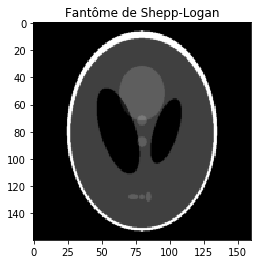

In [45]:
img = shepp_logan_phantom()
img = rescale(img, scale=0.4, mode='reflect', multichannel=False)
L,C = np.shape(img)
print(L,C)
print(np.min(img), np.max(img))

plt.imshow(img, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan')
plt.show()

Comme expliqué précédemment, le principe de Tomographie nécessite d'acquérir des coupes de l'image selon différents angles. Si ce sont les sources d'émissions de rayon X et les capteurs qui sont statiques, cela revient à appliquer des rotations à l'objet / l'image.

Considérons simplement le cas de l'image : par rotation, on risque de perdre de l'information aux bords. Pour réduire cette perte d'information, on fait un zéro padding sur l'image initiale.

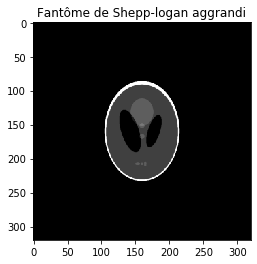

In [46]:
def zero_padding(image):
    M,N = image.shape
    res = np.zeros((M*2,N*2))
    res[int(M/2):int(M*3/2),int(N/2):int(N*3/2)] = np.copy(image)
    return res

imgz = zero_padding(img)
plt.imshow(imgz, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-logan aggrandi')
plt.show()

## Partie 1 : construction du sinogramme à partir de l'objet

Dans le cas discret, la transformée de Radon s'effectue de la sorte :
pour chaque $\theta \in \Theta$, $R_{\theta}(x)$ est un vecteur 1D de taille $L$, dont chaque valeur est la somme de chaque ligne de l'image qui a subi la rotation :
- on applique une rotation de $\theta$ à l'image x (on peut utiliser des fonctions de Python mais on verra que la rotation dépend du choix d'interpolation)
- pour chaque ligne de l'image , on fait la somme des valeurs.

Le sinogramme de $x$, $Rx$ est une matrice de taille $L$x$A$ tel que les colonnes sont $R_{\theta}(x)$.

In [1]:
def radon_transform(img, theta_list):
    R = np.zeros((np.shape(img)[0] , len(theta_list)))
    # rotation de l'image pour chaque angle
    for ind in range(len(theta_list)):
        img_rot = rotate(img, -theta_list[ind])
        R[:,ind] = sum(img_rot)
    return R

# skimage.transform.rotate() :
# interpolation spline
# paramètre optionnel : 'order' pour ordre des splines (entre 0 et 5)

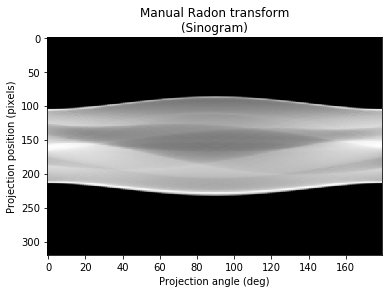

In [48]:
# test
theta_list = np.arange(180)
our_sinogram = radon_transform(imgz, theta_list)

plt.imshow(our_sinogram, cmap=plt.cm.Greys_r, aspect='auto')
plt.title("Manual Radon transform\n(Sinogram)")
plt.xlabel("Projection angle (deg)")
plt.ylabel("Projection position (pixels)")
plt.show()

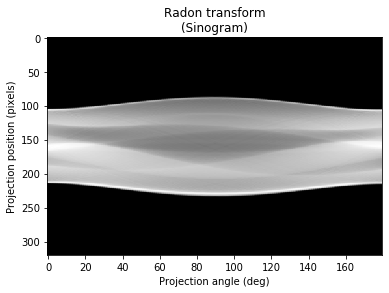

In [49]:
### vérification avec le sinogramme obtenu par radon()
sinogram_radon = radon(imgz, theta=theta_list, circle=True)

plt.imshow(sinogram_radon, cmap=plt.cm.Greys_r, aspect='auto')
plt.title("Radon transform\n(Sinogram)")
plt.xlabel("Projection angle (deg)")
plt.ylabel("Projection position (pixels)")
plt.show()

## Partie 2 : reconstruire l'image à partir du sinogramme

Le sinogramme contient toutes les informations nécessaires à la reconstruction de l'image / de l'objet initial. En réalité, c'est de là que l'on part et on peut utiliser différentes méthodes :

#### • Méthode 1 : rétroprojection filtrée

#### • Méthode 2 : itératives par projection (ART)

#### • Méthode 3 : formulation variationnelle

Elles ont toutes besoin de définir l'adjoint de l'opérateur de la transformée de Radon $R$ que l'on note $R*$. Il est défini par :

$$ R^*S = \sum_{i} R_{\theta_i}^* S_i $$

Avec $S$ le sinogramme, et $S_i$ le sinogramme partiel associé à l'angle $\theta$ 

Les 3 méthodes n'ont pas les même défauts. L'efficacité des méthodes 1 et 2 dépendant du nombre de direction (angles).

On va comparer les images reconstruites avec l'image de référence à l'aide du PSNR. Le PSNR est un bon indicateur de reconstruction car notre image de base a beaucoup de contraste.

On rappelle que la valeur max du PSNR est 100. Plus la valeur du PSNR est grande, plus l'image reconstruite est fidèle à l'image de référence.

In [50]:
## fct pour remettre les valeurs de l'image entre 0 et 1
def normalize_img(img_test):
    img_test += np.abs(np.min(img_test))
    range_values = np.abs(np.max(img_test) - np.min(img_test))
    return img_test/range_values

0.0 1.0


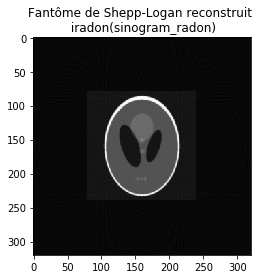

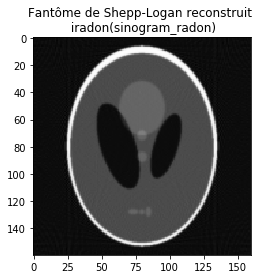

PSNR de référence :  25.84277900643425


In [51]:
### CE QU'ON SOUHAITE AVOIR :
### avec iradon()
iradon_sinogram_radon = iradon(sinogram_radon) # par défaut, filtre ramp
## crop image
crop_iradon_sinogram_radon = normalize_img(iradon_sinogram_radon[int(L/2):L+int(L/2),int(C/2):C+int(C/2)])
print(np.min(crop_iradon_sinogram_radon), np.max(crop_iradon_sinogram_radon))

plt.imshow(iradon_sinogram_radon, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n iradon(sinogram_radon)')
plt.show()

plt.imshow(crop_iradon_sinogram_radon, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n iradon(sinogram_radon)')
plt.show()

print("PSNR de référence : ", psnr(img, crop_iradon_sinogram_radon)) #img true, img_test

In [52]:
## testons plusieurs filtres avec iradon()


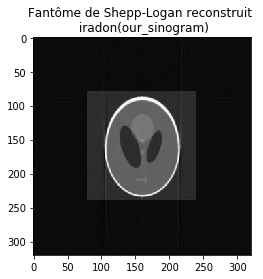

PSNR :  17.32286655798604


In [53]:
iradon_our_sinogram = iradon(our_sinogram)
crop_iradon_our_sinogram = normalize_img(iradon_our_sinogram[int(L/2):L+int(L/2),int(C/2):C+int(C/2)])

plt.imshow(iradon_our_sinogram, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n iradon(our_sinogram)')
plt.show()

print("PSNR : ", psnr(img, crop_iradon_our_sinogram)) #img true, img_test

___
Commentaire : Ici on calcule le PSNR pour deux images reconstruites avec iradon() :
- une image dont le sinogramme a été calculé par skimage.transform.radon()
- une image dont le sinogramme a été calculé par nous

On voit qu'on perd presque 10 pts de PSNR avec notre sinogramme. On va voir si les méthodes de reconstruction (rétroprojection non-filtrée / filtrée, ART, variationnelle) permettent de regagner ces 10 pts.
___


### Méthode 1 : Rétroprojection filtrée

Il y a deux aspects de la méthode : rétroprojection et filtrage.

La rétroprojection se place dans le domaine spatial et le filtrage dans le domaine fréquentiel.
ressources :
- https://www.youtube.com/watch?v=pZ7JlXagT0w

In [54]:
def retroprojection_non_filtree(sinogram, theta_list):
    L,A = np.shape(sinogram) #320,160
    temp = np.zeros((L,L,A)) #320,320,160
    img_rec = np.zeros((L,L)) #320,320
    for index_angle in range(A):
        #print("angle numéro :", index_angle)
        tempp = np.zeros((L, L))
        # sélection de la colonne
        col = sinogram[:,index_angle]
        for index_line in range(len(col)):
            #print("valeur à copier :", col[index_line])
            tempp[index_line,:] = np.repeat(col[index_line],L)
            #print(tempp[index_line,:])
        temp[:,:,index_angle] = rotate(tempp, theta_list[index_angle])
        #plt.imshow(temp[:,:,index_angle], cmap=plt.cm.Greys_r)
        #plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée')
        #plt.show()
        img_rec += temp[:,:,index_angle]
    
    #return img_rec
    return normalize_img(rotate(img_rec, 90))

0.0 1.0


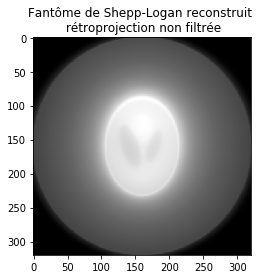

PSNR :  4.766616258346364


In [55]:
### test
our_img_rec = retroprojection_non_filtree(our_sinogram, theta_list)
print(np.min(our_img_rec), np.max(our_img_rec))

crop_our_img_rec = our_img_rec[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

plt.imshow(our_img_rec, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée')
plt.show()

print("PSNR : ", psnr(img, crop_our_img_rec)) #img true, img_test

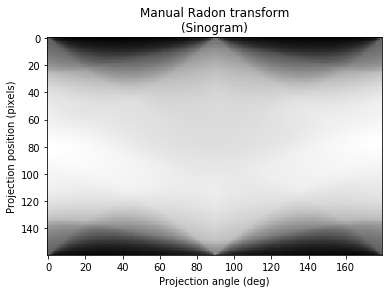

In [56]:
## sinogramme de l'image reconstruite 

sino_retro_nonfilt = radon_transform(crop_our_img_rec, theta_list)

plt.imshow(sino_retro_nonfilt, cmap=plt.cm.Greys_r, aspect='auto')
plt.title("Manual Radon transform\n(Sinogram)")
plt.xlabel("Projection angle (deg)")
plt.ylabel("Projection position (pixels)")
plt.show()

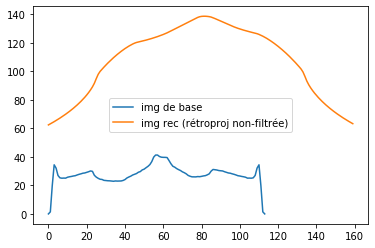

In [57]:
plt.plot(our_sinogram[our_sinogram[:,0]>0,0], label = "img de base")
plt.plot(sino_retro_nonfilt[sino_retro_nonfilt[:,0]>0,0], label = "img rec (rétroproj non-filtrée)")
plt.legend()
plt.show()

____
Commentaire : ne pas afficher le sinogramme de l'image reconstruite
___

### Test variation de méthode d'interpolation 

Au dessus, l'interpolation est bi-linéaire par défaut de la fonction rotate de skimage.transform car on a une image en niveaux de gris. Testons l'interpolation à 0 (nearest-neighbor), 2 (bi-quadratic), 3 (bi-cubique).

Pour un grand nombre d'angles, on ne verra pas forcément la différence entre les interpolations.
Testons les différentes interpolations sur un faible nombre d'angles entre 0 et 180°.

In [72]:
theta_list_interpol = np.arange(0,180,4)
print(len(theta_list_interpol))
our_sinogram2 = radon_transform(imgz, theta_list_interpol)

45


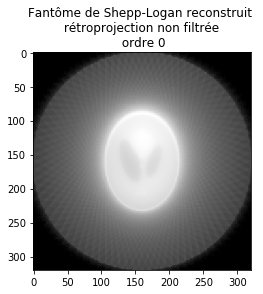

PSNR :  4.788655274136113


In [73]:
## nearest-neighbour
def retroprojection_non_filtree(sinogram, theta_list):
    L,A = np.shape(sinogram) #320,160
    temp = np.zeros((L,L,A)) #320,320,160
    img_rec = np.zeros((L,L)) #320,320
    for index_angle in range(A):
        #print("angle numéro :", index_angle)
        tempp = np.zeros((L, L))
        # sélection de la colonne
        col = sinogram[:,index_angle]
        for index_line in range(len(col)):
            #print("valeur à copier :", col[index_line])
            tempp[index_line,:] = np.repeat(col[index_line],L)
            #print(tempp[index_line,:])
            
        temp[:,:,index_angle] = rotate(tempp, theta_list[index_angle], order = 0)
        #plt.imshow(temp[:,:,index_angle], cmap=plt.cm.Greys_r)
        #plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée')
        #plt.show()
        img_rec += temp[:,:,index_angle]
    
    #return img_rec
    return normalize_img(rotate(img_rec, 90))

### test
our_img_rec_order0 = retroprojection_non_filtree(our_sinogram2, theta_list_interpol)
crop_our_img_rec0 = our_img_rec_order0[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

plt.imshow(our_img_rec_order0, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée \n ordre 0')
plt.show()

print("PSNR : ", psnr(img, crop_our_img_rec0)) #img true, img_test

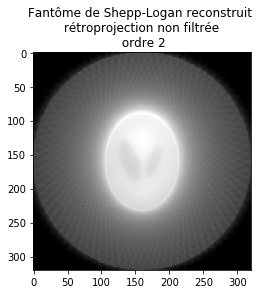

PSNR :  4.7916133982997335


In [74]:
## bi-quadratique
def retroprojection_non_filtree(sinogram, theta_list):
    L,A = np.shape(sinogram) #320,160
    temp = np.zeros((L,L,A)) #320,320,160
    img_rec = np.zeros((L,L)) #320,320
    for index_angle in range(A):
        #print("angle numéro :", index_angle)
        tempp = np.zeros((L, L))
        # sélection de la colonne
        col = sinogram[:,index_angle]
        for index_line in range(len(col)):
            #print("valeur à copier :", col[index_line])
            tempp[index_line,:] = np.repeat(col[index_line],L)
            #print(tempp[index_line,:])
            
        temp[:,:,index_angle] = rotate(tempp, theta_list[index_angle], order = 2)
        #plt.imshow(temp[:,:,index_angle], cmap=plt.cm.Greys_r)
        #plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée')
        #plt.show()
        img_rec += temp[:,:,index_angle]
    
    #return img_rec
    return normalize_img(rotate(img_rec, 90))

### test
our_img_rec_order2 = retroprojection_non_filtree(our_sinogram2, theta_list_interpol)
crop_our_img_rec2 = our_img_rec_order2[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

plt.imshow(our_img_rec_order2, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée \n ordre 2')
plt.show()
print("PSNR : ", psnr(img, crop_our_img_rec2)) #img true, img_test

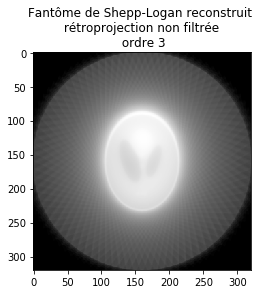

PSNR :  4.793035509424411


In [75]:
## bi-cubique
def retroprojection_non_filtree(sinogram, theta_list):
    L,A = np.shape(sinogram) #320,160
    temp = np.zeros((L,L,A)) #320,320,160
    img_rec = np.zeros((L,L)) #320,320
    for index_angle in range(A):
        #print("angle numéro :", index_angle)
        tempp = np.zeros((L, L))
        # sélection de la colonne
        col = sinogram[:,index_angle]
        for index_line in range(len(col)):
            #print("valeur à copier :", col[index_line])
            tempp[index_line,:] = np.repeat(col[index_line],L)
            #print(tempp[index_line,:])
        temp[:,:,index_angle] = rotate(tempp, theta_list[index_angle], order = 3)
        #plt.imshow(temp[:,:,index_angle], cmap=plt.cm.Greys_r)
        #plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée')
        #plt.show()
        img_rec += temp[:,:,index_angle]
    
    #return img_rec
    return normalize_img(rotate(img_rec, 90))

### test
our_img_rec_order3 = retroprojection_non_filtree(our_sinogram2, theta_list_interpol)
crop_our_img_rec3 = our_img_rec_order3[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

plt.imshow(our_img_rec_order3, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée \n ordre 3')
plt.show()
print("PSNR : ", psnr(img, crop_our_img_rec3)) #img true, img_test

___
Commentaire :

Le problème de la rétroprojection non-filtrée est de créer un halo autour du fantôme de Shepp-Logan qui pollue l'image. On voit que la valeur du PSNR est très basse à cause du halo...
La simple rétroprojection n'est définitivement pas une bonne méthode de reconstruction.

Pour un faible nombre d'angles, on voit la différence entre les différentes méthodes d'interpolation. Ici, pour 45 angles, l'interpolation par nearest-neighbour ne permet pas du tout de reconstruire l'image fidèlement. Avec bilinéaire et bicubique on obtient une meilleure approximation que l'ordre 1, mais la valeur n'augmente pas non plus beaucoup car le halo est toujours créé...

___

### Rétroprojection filtrée
- https://www.hindawi.com/journals/ijbi/2011/693795/
- https://www.youtube.com/watch?v=pZ7JlXagT0w

Avec la rétroprojection simple, les basses fréquences sont beaucoup plus extraites que les hautes fréquences. Les hautes fréquences sont celles qui donnent les détails d'une image.
Ici on voit ce problème par la création du halo.

L'opération de filtrage de la rétroprojection filtrée permet donc de filtrer certaines basses fréquences et laisser passer les hautes fréquences pour enlever le halo, augmenter la définition et les contours de l'image.

C'est une opération qui s'effectue dans le domaine des fréquences, et s'applique sur le sinogramme. Ainsi, on applique d'abord une transformée de Fourier au sinogramme. Pour cela, on applique une transformée de Fourier 1D sur chaque projection du sinogramme, puis on multiplie par notre filtre.

On repasse dans le domaine spatial en faisant une transformée inverse de Fourier, puis on peut appliquer la rétroprojection simple.

L'image reconstruite doit être bien meilleure qu'en rétroprojection simple.

Filtres passe-haut :
- rampe
- rampe adoucie

A l'inverse, les filtres passe-bas vont enlever le bruit (véhiculés par les hautes fréquences) mais ne vont pas garder les contours.
- butterworth
- hanning
- hamming
- shepp logan

Aucun filtre n'est parfait, le choix du filtre se fait en général empiriquement, ou selon les connaissances a priori sur le signal.

In [19]:
def filtrage(sinogram,filtre,theta_list):
    T,A = sinogram.shape #Taille image, nb d'angles
    res = sinogram*0.
    for j in range(A): #colonnes = angles
        four = ft.fft(sinogram[:,j])
        res[:,j] = np.real(ft.ifft(four*filtre(T)))
    return res

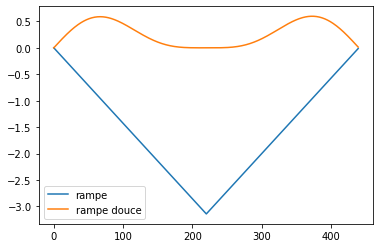

In [20]:
## code Simon
def rampe(T): ## pas bonne je crois
    step = 2*np.pi/T
    w = np.arange(-np.pi,np.pi,step)
    r = abs(w) # approx filtre rampe
    filt = ft.fftshift(r)
    return filt

plt.plot(-rampe(T=440), label="rampe")

def rampe_adoucie(T):
    a=1 # param d'adoucissage (a=0 non adouci, a=1 adouci)
    step = 2*np.pi/T
    w = np.arange(-np.pi, np.pi, step)
    rn1 = abs(w)  # filtre rampe
    rn2 = a*np.hanning(T)  #sinc window with 'a' modifying the cutoff freqs
    r = rn1*(rn2)**2             #modulation of ramp filter with sinc window
    filt = ft.fftshift(r) 
    return filt

plt.plot(rampe_adoucie(T=440), label="rampe douce")

plt.legend()
plt.show()

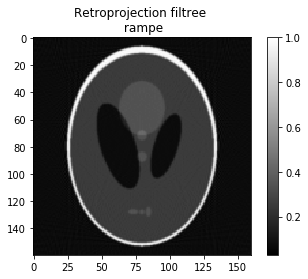

PSNR :  23.055215013525885


In [21]:
sinoFilt = filtrage(our_sinogram,rampe,theta_list)
imrec_rampe = retroprojection_non_filtree(sinoFilt, theta_list)
L,C = np.shape(img)
crop_imrec_rampe = imrec_rampe[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

plt.imshow(crop_imrec_rampe,cmap='gray')
plt.title("Retroprojection filtree \n rampe")
plt.colorbar()
plt.show()

print("PSNR : ", psnr(img, crop_imrec_rampe)) #img true, img_test


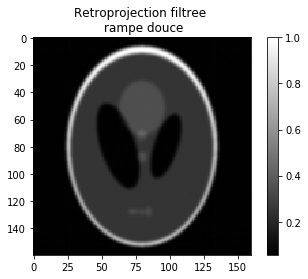

PSNR :  21.26105688869402


In [22]:
sinoFilt = filtrage(our_sinogram,rampe_adoucie,theta_list)
imrec_rampedouce = retroprojection_non_filtree(sinoFilt, theta_list)
crop_imrec_rampedouce = imrec_rampedouce[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

plt.imshow(crop_imrec_rampedouce,cmap='gray')
plt.title("Retroprojection filtree \n rampe douce")
plt.colorbar()
plt.show()

print("PSNR : ", psnr(img, crop_imrec_rampedouce)) #img true, img_test

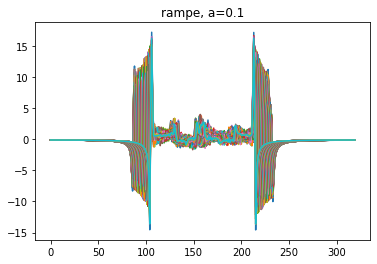

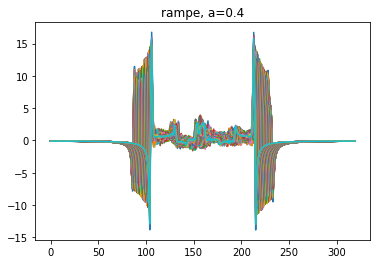

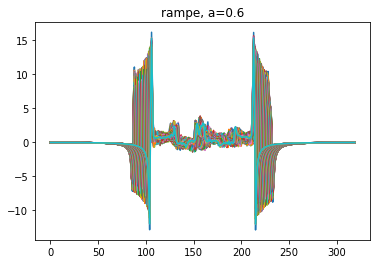

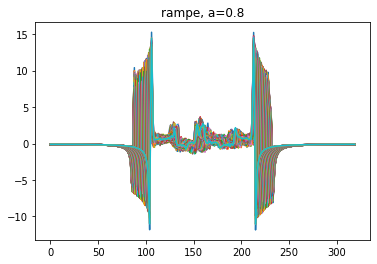

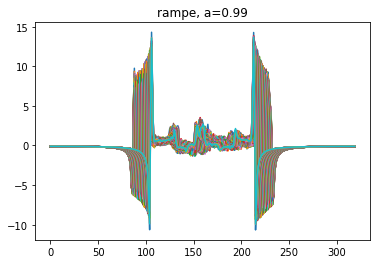

In [23]:
## code zaza
def arange2(start, stop=None, step=1):
    """#Modified version of numpy.arange which corrects error associated with non-integer step size"""
    if stop == None:
        a = np.arange(start)
    else: 
        a = np.arange(start, stop, step)
        if a[-1] > stop-step:   
            a = np.delete(a, -1)
    return a

def rampe_zaza(sinogram, a):
    T,A = np.shape(sinogram)
    ## paramètre a : permet d'adoucir la rampe (a proche de 1) ou rampe pure (a proche de 0)
    step = 2*np.pi/T
    w = arange2(-np.pi, np.pi, step)
    if len(w) < T:
        w = np.concatenate([w, [w[-1]+step]]) #depending on image size, it might be that len(w) =  
                                              #projLen - 1. Another element is added to w in this case
    rn1 = abs(2/a*np.sin(a*w/2));  #approximation of ramp filter abs(w) with a funciton abs(sin(w))
    rn2 = np.sin(a*w/2)/(a*w/2);   #sinc window with 'a' modifying the cutoff freqs
    r = rn1*(rn2)**2;              #modulation of ramp filter with sinc window
    
    filt = ft.fftshift(r)   
    filtSino = np.zeros((T, A))
    for i in range(A):
        projfft = ft.fft(sinogram[:,i])
        filtProj = projfft*filt
        filtSino[:,i] = np.real(ft.ifft(filtProj))
        
    return np.array(filtSino)

#print(np.shape(rampe_zaza(our_sinogram)))
for a in [0.1,0.4,0.6,0.8,0.99]:
    plt.figure()
    plt.plot(rampe_zaza(our_sinogram,a), label="rampe")
    plt.title("rampe, a={}".format(a))

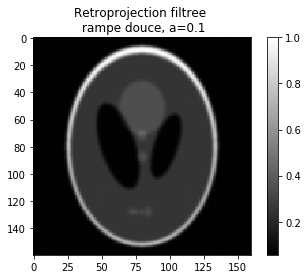

PSNR :  23.053222676062198


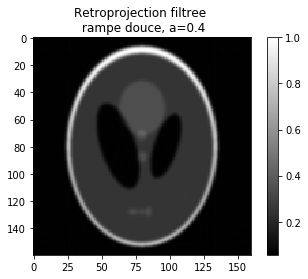

PSNR :  23.02614467175376


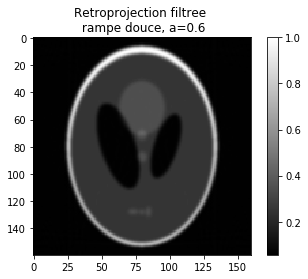

PSNR :  23.02369761888615


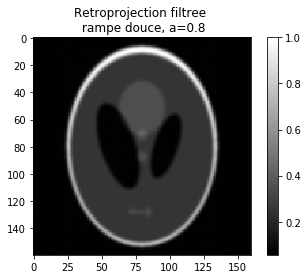

PSNR :  22.93183038005346


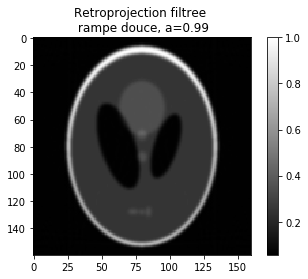

PSNR :  22.786139768485


In [24]:
#sinoFilt_zaza = filtrage_zaza(our_sinogram,rampe_zaza,theta_list)
for a in [0.1,0.4,0.6,0.8,0.99]:
    plt.figure()
    sinoFilt_zaza = rampe_zaza(our_sinogram, a)
    imrec_rampezaza = retroprojection_non_filtree(sinoFilt_zaza, theta_list)
    crop_imrec_rampezaza = imrec_rampezaza[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

    plt.imshow(crop_imrec_rampedouce,cmap='gray')
    plt.title("Retroprojection filtree \n rampe douce, a={}".format(a))
    plt.colorbar()
    plt.show()

    print("PSNR : ", psnr(img, crop_imrec_rampezaza)) #img true, img_test

___
Commentaire : normalement, on doit avoir une meilleure reconstruction avec la rampe douce (avec a proche de 1) qu'avec la rampe pure, mais ici on observe l'inverse
___

Ensuite, afficher PSNR image reconstruite en fonction du nb de projections

In [ ]:
## rajouter du bruit pour voir comment ça joue sur la reconstruction (selon le type de bruit aussi)

In [ ]:
## Méthode 2 : ITÉRATIVES PAR PROJECTION

In [ ]:
## Méthode 3 : FORMULATION VARIATIONNELLE